<a href="https://colab.research.google.com/github/Edriczz/Formal_logic/blob/main/Edge_Chromatic_Number_Without_Vizing_Theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edrico Septian Elyazar \
5002221101 \
Formal Logic

##Determining Edge Chromatic Number

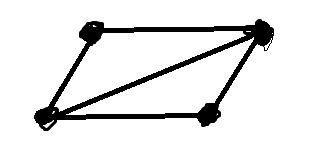

let this graph name is parallelogram_diag

In [1]:
# prompt: instal z3 solver library

!pip install z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 59.7 MB/s eta 0:00:00


In [8]:
from z3 import Solver, Int, And, Distinct, sat

def convert_adj_matrix_to_graph_data(adj_matrix):
    """
    Converts an adjacency matrix to the number of vertices and a list of edges,
    treating the graph as a simple undirected graph (no multigraphs, no loops).
    Assumption: adj_matrix is valid and represents a simple undirected graph.

    Args:
        adj_matrix (list of list of int): Adjacency matrix.
                                          adj_matrix[i][j] > 0 means an edge exists between i and j.
                                          Values > 1 are treated as 1 (simple graph).
                                          Diagonal (loops) are ignored.
    Returns:
        tuple (int, list): Number of vertices, list of edge tuples for the simple graph.
    """
    num_vertices = len(adj_matrix)
    if num_vertices == 0:
        return 0, []

    edges = []
    # Iterate through the strictly upper triangle (j > i) to process each edge once,
    # and to ignore the diagonal (loops).
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices): # j starts from i + 1
            if adj_matrix[i][j] == 1:
                edges.append((i, j))
    return num_vertices, edges

def get_max_degree(adj_matrix): # This function remains if needed for other analyses, but not for starting k
     #this function is used when we want to use vizing theorem, but in this notebook we don't use it
    """
    Calculates the maximum degree (Delta) of a simple undirected graph.
    Loops are ignored as they don't exist in a simple graph.
    Assumption: adj_matrix is valid and represents a simple undirected graph.

    Args:
        adj_matrix (list of list of int): Adjacency matrix. Values > 1 are treated as 1.
    Returns:
        int: Maximum degree (Delta) of the simple graph.
    """
    num_vertices = len(adj_matrix)
    if num_vertices == 0:
        return 0

    max_deg = 0
    for i in range(num_vertices):
        current_vertex_degree = 0
        for j in range(num_vertices):
            if i == j: # Ignore diagonal (loops not in simple graph)
                continue
            if adj_matrix[i][j] > 0: # Edge to another vertex
                current_vertex_degree += 1
        if current_vertex_degree > max_deg:
            max_deg = current_vertex_degree

    return max_deg

def solve_edge_coloring_simple_graph(adj_matrix, k_colors):
    """
    Attempts to find a k-edge-coloring for the simple graph derived from adj_matrix using Z3.
    Assumption: adj_matrix is valid and represents a simple undirected graph.

    Args:
        adj_matrix (list of list of int): Adjacency matrix.
        k_colors (int): Number of available colors.
    Returns:
        list or None: List of colors corresponding to the edge order if k-coloring exists,
                      otherwise None.
    """
    num_vertices, edges = convert_adj_matrix_to_graph_data(adj_matrix)

    if not edges:
        return []

    s = Solver()
    edge_vars = [Int(f"edge_{i}_color") for i in range(len(edges))]

    # Constraint 1: Each edge's color must be between 1 and k_colors.
    for i in range(len(edges)):
        s.add(And(edge_vars[i] >= 1, edge_vars[i] <= k_colors))

    # Constraint 2: Edges sharing a common vertex must have different colors.
    for v_idx in range(num_vertices):
        incident_edge_color_vars = []
        for edge_idx, (u, v_node) in enumerate(edges):
            if u == v_idx or v_node == v_idx:
                incident_edge_color_vars.append(edge_vars[edge_idx])

        if len(incident_edge_color_vars) > 1:
            s.add(Distinct(incident_edge_color_vars))

    if s.check() == sat:
        model = s.model()
        coloring_list = [model[edge_vars[i]].as_long() for i in range(len(edges))]
        return coloring_list
    else:
        return None

def find_edge_chromatic_number_simple_graph(adj_matrix):
    """
    Finds the edge chromatic number of a simple undirected graph.
    Starts searching k from 1.
    Assumption: adj_matrix is valid and represents a simple undirected graph.

    Args:
        adj_matrix (list of list of int): Adjacency matrix.
    Returns:
        tuple (int, list): (edge_chromatic_number, list_of_colored_edges).
                           Returns (0, []) for an empty graph.
                           Returns (-1, []) if no coloring is found.
    """
    num_vertices, edge_list_for_output = convert_adj_matrix_to_graph_data(adj_matrix)

    if not edge_list_for_output:
        return 0, []

    # Upper bound for k is the number of edges.
    # For a simple graph, a tighter upper bound is Delta + 1, or number of vertices - 1.
    # However, for simple iteration, number of edges is a safe upper bound.
    max_possible_k = len(edge_list_for_output)
    if num_vertices > 1 : # For a connected graph with N vertices, max k can be N-1 (e.g., K_N) or N (e.g., odd C_N)
         max_possible_k = min(max_possible_k, num_vertices) # K_N has chi'(K_N) = N-1 or N

    # Start k from 1
    for k in range(1, max_possible_k + 1):
        print(f"Attempting to edge-color the simple graph with {k} colors...")
        coloring_result_list = solve_edge_coloring_simple_graph(adj_matrix, k)

        if coloring_result_list is not None:
            print(f"Successfully found an edge coloring with {k} colors.")
            final_coloring_representation = []
            # Assuming lengths will always match if logic is correct
            for i in range(len(edge_list_for_output)):
                final_coloring_representation.append( (edge_list_for_output[i], coloring_result_list[i]) )
            return k, final_coloring_representation
        else:
            print(f"Failed to find an edge coloring with {k} colors.")

    print(f"Could not determine the edge chromatic number after trying up to k={max_possible_k + 1}.")
    return -1, []




In [9]:

if __name__ == '__main__':
# --- Test Cases (Simple Undirected Graph) ---
    print("\n--- Example 1: Parallelogram with a diagonal ---")
    # Vertices: 0 (bottom-left), 1 (top-left), 2 (top-right), 3 (bottom-right)
    # Edges: (0,1), (1,2), (2,3), (3,0) and diagonal (0,2)
    # Max degree (Delta) = 3 (at vertices 0 and 2). Expected chi' = 3.
    adj_parallelogram_diag = [
        [0, 1, 1, 1],  # Vertex 0 to 1, 2, 3
        [1, 0, 1, 0],  # Vertex 1 to 0, 2
        [1, 1, 0, 1],  # Vertex 2 to 0, 1, 3
        [1, 0, 1, 0]   # Vertex 3 to 0, 2
    ]
    chi_prime_pd, coloring_pd = find_edge_chromatic_number_simple_graph(adj_parallelogram_diag)
    print(f"Edge chromatic number for parallelogram with diagonal: {chi_prime_pd}")
    if chi_prime_pd != -1:
        print("Coloring:")
        for edge, color in coloring_pd:
            print(f"  Edge {edge}: Color {color}")



--- Example 8: Parallelogram with a diagonal ---
Attempting to edge-color the simple graph with 1 colors...
Failed to find an edge coloring with 1 colors.
Attempting to edge-color the simple graph with 2 colors...
Failed to find an edge coloring with 2 colors.
Attempting to edge-color the simple graph with 3 colors...
Successfully found an edge coloring with 3 colors.
Edge chromatic number for parallelogram with diagonal: 3
Coloring:
  Edge (0, 1): Color 1
  Edge (0, 2): Color 3
  Edge (0, 3): Color 2
  Edge (1, 2): Color 2
  Edge (2, 3): Color 1
